# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 09/14/2021

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
!pip install geopandas
import geopandas as gpd #to work with spatial data
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter
import glob #to batch import csv files

     |████████████████████████████████| 1.0 MB 34.6 MB/s 
     |████████████████████████████████| 15.4 MB 35 kB/s 
     |████████████████████████████████| 6.3 MB 47.0 MB/s 


In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [4]:
#Import data files

div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
print(div_wd63.dtypes)

WaterDistrictNumber             int64
HydrologyID                     int64
DiversionName                  object
DiversionTypeDescription       object
MeasurementTypeDescription     object
CFS                           float64
dtype: object


In [ ]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(div_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = div_wd63[div_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [5]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###


all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DiversionDate'], index_col=['DiversionDate'])
  all_files.append(df) #appends dataframes to one file list

In [ ]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

len(all_files)
i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

for f in file_len: #run a for loop to add all plots to figure
  canal_data = all_files[f] #takes an individual diversion point datafram
  ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
  ax[i][j].set_ylabel('Discharge (cfs)')
  ax[i][j].set_xlabel('Time')
  ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0

###---------------------------------------------###
### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
###---------------------------------------------###

for f in file_len:
  canal_data = all_files[f]
  fig = plt.figure(figsize= (9,7))
  ax = fig.add_subplot(1,1,1)
  ax.plot(canal_data.index, canal_data['CFS'], 'o')
  ax.set_ylabel('Discharge (cfs)')
  ax.set_xlabel('Time')
  ax.title.set_text(canal_data['DiversionName'].iloc[0])
  file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
  plt.savefig(file_path) #exports the file 


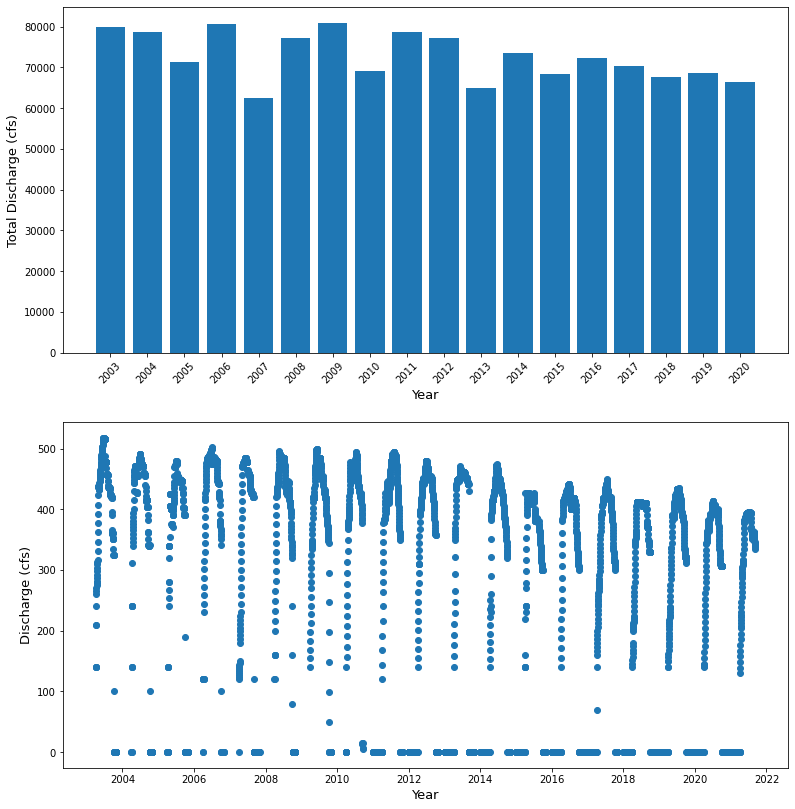

In [7]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

## Start with one known canal: Ridenbaugh

ridenbaugh = all_files[84] #subset to the Ridenbaugh canal
years = np.array(np.arange(2003,2021,1)) #creates an array for the years
totals = np.empty(len(years)) #create an empty vector to store sums

for y in range(len(years)):
  Ix = ridenbaugh.index.year == years[y] #index the year
  subset_year = ridenbaugh[Ix] #subset the data to the specified year
  totals[y] = sum(subset_year['CFS']) #sum the total discharge throughout the year
  #need to find a way to normalize the total for the year

fig2 = plt.figure(figsize=(13,14)) #create a figure
ax = fig2.add_subplot(2,1,1) #add a subplot
ax.bar(years, totals) #plot the data as a bar chart
ax.set_xlabel('Year', size=13) #set the x-axis label 
ax.set_ylabel('Total Discharge (cfs)', size=13) #set the y-axis label
plt.xticks(years, years, rotation= 45) #create label for all years
ax2 = fig2.add_subplot(2,1,2) # create a second subplot
ax2.plot(ridenbaugh.index, ridenbaugh['CFS'], 'o') #plot the daily dicharge vs time
ax2.set_ylabel('Discharge (cfs)', size=13) #set the y-axis label
ax2.set_xlabel('Year', size=13) #set the x-axis label
plt.show()

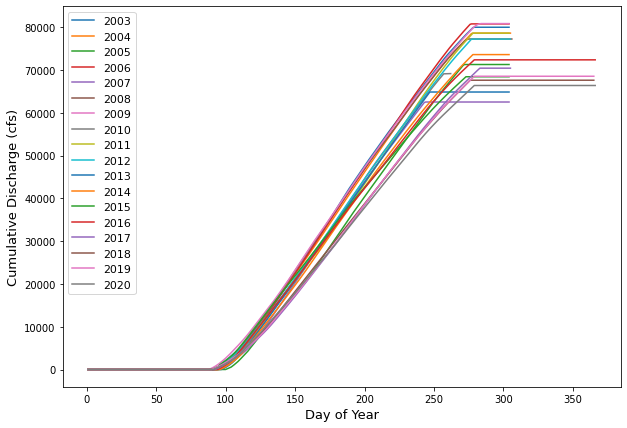

In [34]:
## CUMULATIVE SUMS DAILY ##

#Create a loop to sum the total water diverted for every year

cumsum_years = []

for j in range(len(years)):
  Ix = ridenbaugh.index.year == years[j] #index the year
  subset_year = ridenbaugh[Ix] #subset the data to the specified year
  series_cfs = pd.Series(subset_year['CFS'])
  cumsum_daily = series_cfs.cumsum()
  cumsum_years.append(cumsum_daily)

#Plot the cumulative sum by the day of year

fig3 = plt.figure(figsize = (10,7))
ax = fig3.add_subplot(1,1,1)
legend = []
for i in range(len(years)):
  ax.plot(cumsum_years[i].index.dayofyear, cumsum_years[i])
plt.legend(years, fontsize=11)
ax.set_ylabel('Cumulative Discharge (cfs)', size=13)
ax.set_xlabel('Day of Year', size=13)
plt.show()

In [52]:
## FIND THE DATE WHERE HALF OF THE FLOW HAS GONE THROUGH ##

def nearest(Data, search_value):
  '''
  Define a function to find the date with the value closet to search value
  
  INPUTS:
  Data = the set of data you are searching through
  search_value = the value you want to be closest to

  OUTPUTS:
  Indexed value closest to search value
  '''
  Ix = (np.abs(Data-search_value)).argmin()
  return Data[Ix]

#Use a loop to find the date where half of the diversion flow has passed through
#the system

mid_dates = []
for i in range(len(years)):
  subset_year = cumsum_years[i]
  half_fill = round(0.5*max(subset_year))
  date = nearest(subset_year, half_fill)
  Ix_date = subset_year == date
  date = subset_year[Ix_date]
  mid_dates.append(date)

print(mid_dates)
  

[DiversionDate
2003-07-04    40224.7
Name: CFS, dtype: float64, DiversionDate
2004-07-04    39438.5
Name: CFS, dtype: float64, DiversionDate
2005-07-09    35778.6
Name: CFS, dtype: float64, DiversionDate
2006-07-06    40604.0
Name: CFS, dtype: float64, DiversionDate
2007-06-22    31294.8
Name: CFS, dtype: float64, DiversionDate
2008-06-30    38395.1
Name: CFS, dtype: float64, DiversionDate
2009-07-05    40572.4
Name: CFS, dtype: float64, DiversionDate
2010-06-28    34372.6
Name: CFS, dtype: float64, DiversionDate
2011-07-11    39475.64
Name: CFS, dtype: float64, DiversionDate
2012-07-05    38424.15
Name: CFS, dtype: float64, DiversionDate
2013-06-24    32230.6
Name: CFS, dtype: float64, DiversionDate
2014-07-06    36737.09
Name: CFS, dtype: float64, DiversionDate
2015-06-28    34039.16
Name: CFS, dtype: float64, DiversionDate
2016-07-03    36151.69
Name: CFS, dtype: float64, DiversionDate
2017-07-12    35359.0
Name: CFS, dtype: float64, DiversionDate
2018-07-07    33836.25
Name: CFS, d

In [ ]:
## NORMALIZE THE DATA FOR EACH YEAR ##



In [ ]:
#Subset by known canals

ny_canal = div_wd63[div_wd63['DiversionName'] == 'NEW YORK'] #export data for new york canal
siebenberg_canal = div_wd63[div_wd63['DiversionName'] == 'SEIBENBERG'] #export data for seibenberg canal
print(ny_canal)

               WaterDistrictNumber  ...     CFS
DiversionDate                       ...        
2010-11-09                      63  ...    0.00
2010-12-14                      63  ...    0.00
2010-12-30                      63  ...    0.00
2011-01-17                      63  ...    0.00
2011-01-18                      63  ...    0.00
...                            ...  ...     ...
2021-03-27                      63  ...  737.78
2021-03-28                      63  ...  736.84
2021-03-29                      63  ...  738.39
2021-03-30                      63  ...  738.63
2021-03-31                      63  ...  732.67

[5196 rows x 6 columns]


In [ ]:
#extract just a certain year from New York canal

div_wd63.head()
div_wd63.info()
div_wd63.index


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 497541 entries, 2021-04-13 to 2020-08-23
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   WaterDistrictNumber         497541 non-null  int64  
 1   HydrologyID                 497541 non-null  int64  
 2   DiversionName               497541 non-null  object 
 3   DiversionTypeDescription    497541 non-null  object 
 4   MeasurementTypeDescription  497541 non-null  object 
 5   CFS                         497541 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 26.6+ MB


DatetimeIndex(['2021-04-13', '2021-04-07', '2021-04-08', '2021-04-09',
               '2021-04-10', '2021-04-11', '2021-04-12', '2021-05-03',
               '2021-04-27', '2021-04-28',
               ...
               '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-24',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21',
               '2020-08-22', '2020-08-23'],
              dtype='datetime64[ns]', name='DiversionDate', length=497541, freq=None)

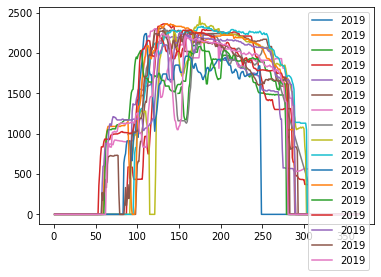

In [ ]:
#Plot the timeseries

#select just the 2010 year
# ny_2010 = ny_canal[ny_canal.index.year == 2010] #index years for 2010
# ny_2010 = ny_2010.sort_index() #sort by oldest to newest
# ny_2020 = ny_canal[ny_canal.index.year == 2020] #index years for 2020
# ny_2020 = ny_2020.sort_index()

# fig1 = plt.figure(figsize=(10,7)) #create a figure
# ax = fig1.add_subplot(1,1,1) #create an axes position for subplot
# ax.plot(ny_2010.index.dayofyear, ny_2010['CFS']) #plot the data
# ax.plot(ny_2020.index.dayofyear, ny_2020['CFS'])
# ax.set_xlabel('Day of Year', fontsize = 12) #create an x-axis label
# ax.set_ylabel('Discharge (cfs)', fontsize = 12) #create a y-axis label
# plt.setp(ax.get_xticklabels(), rotation = 45) #rotate the axis to read better

#format dates so years are on top of one another
#formatdates = DateFormatter('%m-%d')
#ax.xaxis.set_major_formatter(formatdates)
#plt.show()

years = np.array(np.arange(2003,2020))

for n in years: 
  data = ny_canal[ny_canal.index.year == n]
  sort_data = data.sort_index()
  plt.plot(sort_data.index.dayofyear, sort_data['CFS']) #plot the data
  plt.legend(labels=sort_data.index.year)

  


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

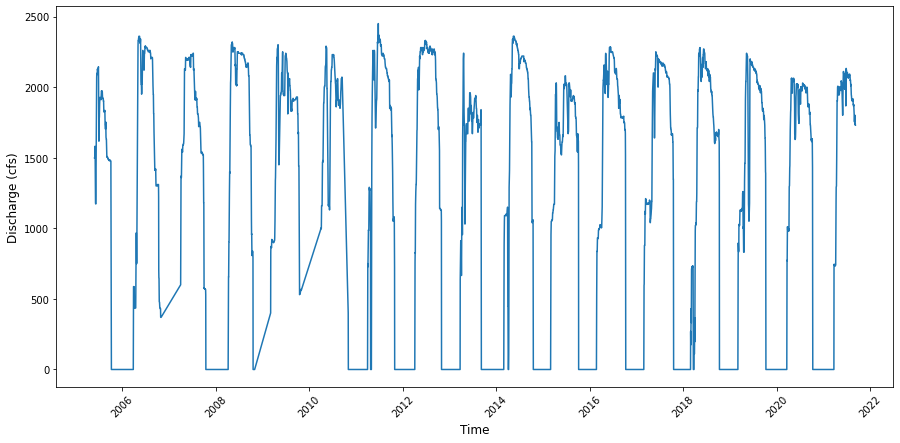

In [ ]:
#plot just the new york canal

ny_canal = ny_canal.sort_index()

fig1 = plt.figure(figsize=(15,7)) #create a figure
ax = fig1.add_subplot(1,1,1) #create an axes position for subplot
ax.plot(ny_canal.index, ny_canal['CFS']) #plot the data
ax.set_xlabel('Time', fontsize = 12) #create an x-axis label
ax.set_ylabel('Discharge (cfs)', fontsize = 12) #create a y-axis label
plt.setp(ax.get_xticklabels(), rotation = 45) #rotate the axis to read better



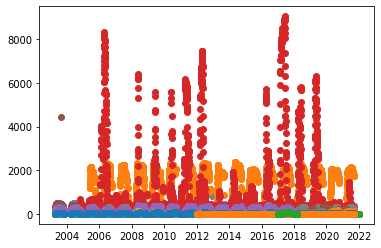

In [ ]:
# figure out the names of each of the canals

hydro_id = np.unique(div_wd63['HydrologyID'])

for n in hydro_id: 
  canal = div_wd63[div_wd63['HydrologyID']== n]
  plt.scatter(canal.index, canal['CFS'])